In [1]:
from typing import Callable, Sequence

import cv2
import cv2.typing as cv2t
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image as IImage
from IPython.display import display
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Rectangle
from matplotlib.ticker import FixedLocator, MultipleLocator
from PIL import Image

In [2]:
def cv2_imshow(img: np.ndarray) -> None:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.imshow(img, "gray")
    ax.set_axis_off()
    # is_success, img = cv2.imencode(".png", img)
    # if is_success:
    #     display(IImage(img))
    # else:
    #     print("Can't display image.")

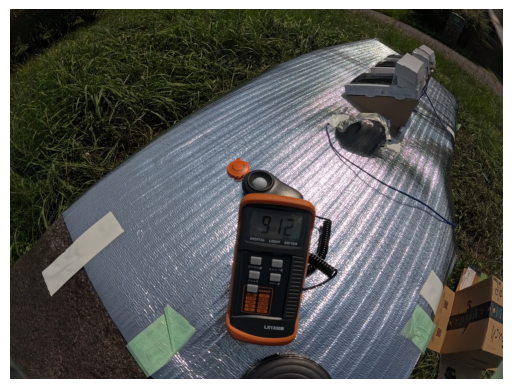

In [3]:
src_img = cv2.imread("../data/src_images/IMG_20240708_132157_339.jpg")
img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
cv2_imshow(img)

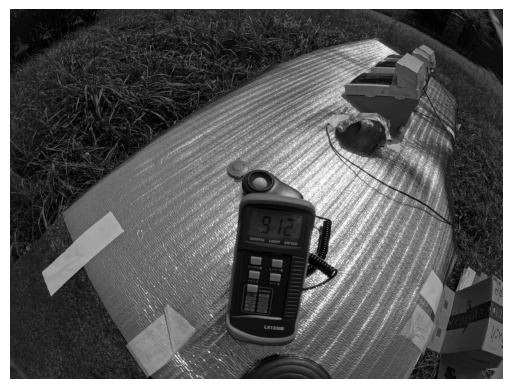

In [4]:
img_gray = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)
cv2_imshow(img_gray)

In [5]:
def crop_transform_show_digits(
    src: cv2t.MatLike,
    pnts: tuple[tuple[int, int], ...],
    dstsize: tuple[int, int],
    *,
    imshow: bool = False,
    roi: tuple[int, int, int, int] | None = None,
    close_up_area: tuple[tuple[int, int], tuple[int, int]] | None = None,
):
    """Crops and rectifies a target area of an image to a rectangle

    Args:
        src (cv2t.MatLike): A source image.
        pnts (tuple[tuple[int, int], ...]): Each vertex of the area to be cropped. The order is clockwise.
        dstsize (tuple[int, int]): Image size after rectangle correction.
        imshow (bool, optional): Whether to compare images before and after conversion.  Defaults to False.
        roi (tuple[int, int, int, int] | None, optional): _description_. Defaults to None.
        close_up_area (tuple[tuple[int, int], tuple[int, int]] | None, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    pts1 = np.array(pnts, np.float32)
    height, width = dstsize
    pts2 = np.array([[0, 0], [width, 0], [width, height], [0, height]], np.float32)

    trans_mat = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(src, trans_mat, (width, height))

    if imshow:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        if roi is None:
            xmin, ymin = 0, 0
            ymax, xmax = src.shape
        else:
            xmin, xmax, ymin, ymax = roi
        axes[0].imshow(
            # src[ymin : ymax + 1, xmin : xmax + 1],
            src,
            cmap=plt.get_cmap("Greys_r"),
            extent=[xmin - 0.5, xmax + 0.5, ymax + 0.5, ymin - 0.5],
        )
        axes[0].add_patch(Polygon(pnts, fc="None", ec="red", alpha=0.5))
        if close_up_area is not None:
            axes[0].set_xlim(close_up_area[0])
            axes[0].set_ylim(close_up_area[1][::-1])
        axes[0].set_xticks(
            np.arange(close_up_area[0][0], close_up_area[0][1], 50), minor=True
        )
        axes[0].set_yticks(
            np.arange(close_up_area[1][0], close_up_area[1][1], 50), minor=True
        )
        axes[1].imshow(dst, cmap=plt.get_cmap("Greys_r"))

    return dst

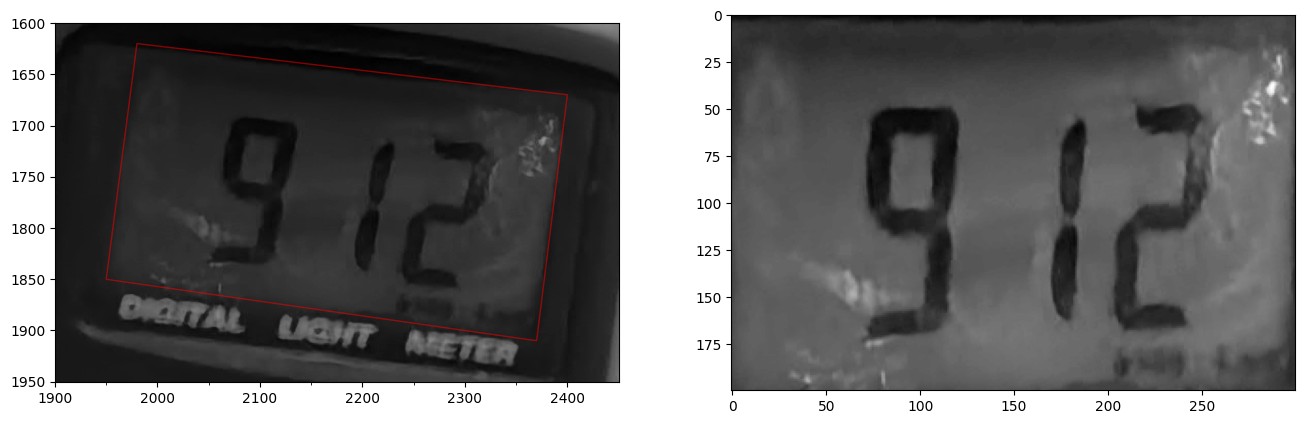

In [6]:
crop_area_ver = ((1980, 1620), (2400, 1670), (2370, 1910), (1950, 1850))
close_up_area = ((1900, 2450), (1600, 1950))
croped_image = crop_transform_show_digits(
    img_gray,
    crop_area_ver,
    (200, 300),
    imshow=True,
    # (0, img_gray.shape[1], 0, img_gray.shape[0])
    close_up_area=close_up_area,
)

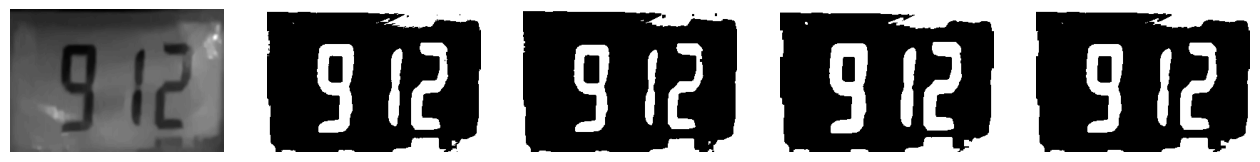

In [7]:
blured = cv2.GaussianBlur(croped_image, ksize=(15, 15), sigmaX=2)
blured = cv2.edgePreservingFilter(blured, sigma_s=110, sigma_r=0.01)
binary = cv2.adaptiveThreshold(
    blured, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301, 1
)
kernel = np.ones((3, 3), np.uint8)
erosion = cv2.erode(binary, kernel, iterations=1)
dilate = cv2.dilate(binary, kernel, iterations=1)
close = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(blured, "gray")
ax.set_axis_off()
ax = fig.add_subplot(1, 5, 2)
ax.imshow(binary, "gray")
ax.set_axis_off()
ax = fig.add_subplot(1, 5, 3)
ax.imshow(erosion, "gray")
ax.set_axis_off()
ax = fig.add_subplot(1, 5, 4)
ax.imshow(dilate, "gray")
ax.set_axis_off()
ax = fig.add_subplot(1, 5, 5)
ax.imshow(close, "gray")
ax.set_axis_off()

In [8]:
def calc_aspect(width: int, height: int) -> float:
    return max(width, height) / min(width, height)


def is_over_area(contour, area) -> bool:
    judge = abs(cv2.contourArea(contour, True)) > area
    # print(judge)
    return judge


def is_inner_aspect(contour, max_aspect, min_aspect) -> bool:
    _, _, w, h = cv2.boundingRect(contour)
    aspect = calc_aspect(w, h)
    return aspect < max_aspect and aspect > min_aspect


def calc_bb_fill_ratio(contour) -> float:
    _, _, w, h = cv2.boundingRect(contour)
    contour_area = abs(cv2.contourArea(contour, True))
    return contour_area / (w * h)


def is_longer_than_width(contour) -> bool:
    _, _, w, h = cv2.boundingRect(contour)
    return h > w

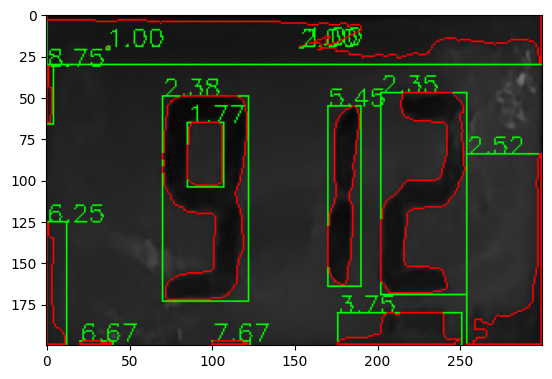

In [9]:
def extract_contours(
    src_img: np.ndarray,
    base_img: np.ndarray | None,
    filter_: Callable[[cv2t.MatLike], bool] | None = None,
) -> Sequence[cv2.typing.MatLike]:
    contours = cv2.findContours(src_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    if filter_ is not None:
        contours = list(filter(filter_, contours))
    if base_img is not None:
        drawing = cv2.cvtColor(base_img, cv2.COLOR_GRAY2RGB)
        min_aspect = 2.3
        max_aspect = 5.5
        for i, contour in enumerate(contours):
            x, y, width, height = cv2.boundingRect(contour)
            aspect = calc_aspect(width, height)
            # if aspect > max_aspect or aspect < min_aspect:
            #     continue
            cv2.rectangle(drawing, (x, y), (x + width, y + height), (0, 255, 0))
            cv2.putText(
                drawing,
                f"{aspect:.2f}",
                (x, y),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=(0, 255, 0),
            )
            # if abs(cv2.contourArea(contour, True)) > 1000:
            drawing = cv2.drawContours(drawing, contours, i, 255)
        plt.imshow(drawing)
        plt.show()
    return contours


contours = extract_contours(close, croped_image)

In [10]:
print(len(contours))

14


In [11]:
filtered_contours = list(
    filter(
        # lambda x: is_inner_aspect(x, 5.5, 2),
        # lambda x: is_over_area(x, 1000) and is_inner_aspect(x, 5.5, 2),
        # lambda x: calc_bb_fill_ratio(x) > 0.4,
        lambda x: is_longer_than_width(x)
        and calc_bb_fill_ratio(x) > 0.4
        and is_inner_aspect(x, 6, 1.5),
        contours,
    )
)
print(len(filtered_contours))

4


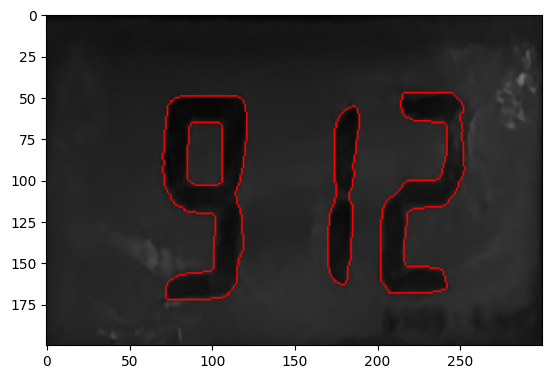

In [12]:
drawing = cv2.cvtColor(croped_image, cv2.COLOR_GRAY2RGB)
for i in range(len(filtered_contours)):
    drawing = cv2.drawContours(drawing, filtered_contours, i, 255)
plt.imshow(drawing)

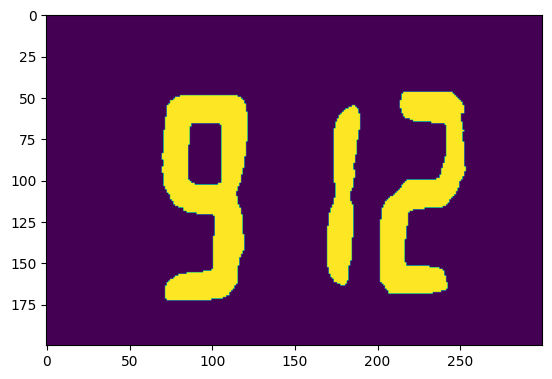

In [13]:
drawing = np.zeros_like(croped_image, np.uint8)
mask = cv2.fillPoly(drawing, filtered_contours, 1)
# morph = cv2.morphologyEx(mask * croped_image, cv2.MORPH_CLOSE, np.ones((7, 7)))

_, masked = cv2.threshold(croped_image * mask, 1, 255, cv2.THRESH_BINARY)

plt.imshow(masked)

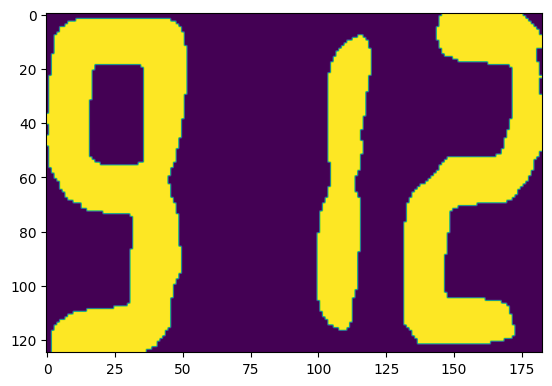

In [14]:
def get_bounding_box(img: np.ndarray) -> tuple[tuple[int, int], tuple[int, int]]:
    # 非ゼロの位置を取得
    nonzero = np.argwhere(img != 0)
    top, left = np.min(nonzero, 0)
    bottom, right = np.max(nonzero, 0)
    return (left, top), (right, bottom)


def remove_margins(img: np.ndarray) -> np.ndarray:
    (left, top), (right, bottom) = get_bounding_box(img)
    return img[
        top:bottom,
        left:right,
    ]


margin_removed_img = remove_margins(masked)
plt.imshow(margin_removed_img)

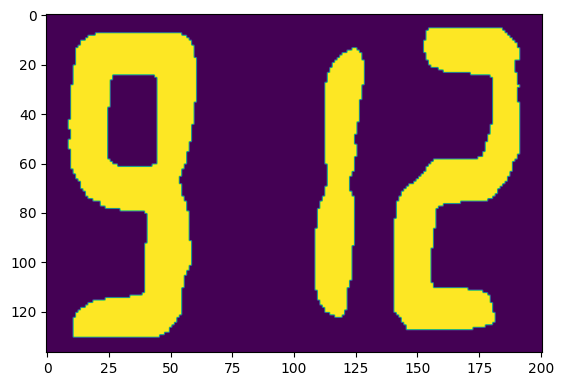

In [22]:
h, w = margin_removed_img.shape[:2]
pad_size_h = h // 20
pad_size_w = w // 20
padding = cv2.copyMakeBorder(
    margin_removed_img,
    pad_size_h,
    pad_size_h,
    pad_size_w,
    pad_size_w,
    cv2.BORDER_CONSTANT,
    value=0,
)
cv2.imwrite("../data/processed_images/processed_sample_pad.png", padding)
plt.imshow(padding)

In [15]:
cv2.imwrite("../data/processed_images/processed_sample.png", margin_removed_img)

True

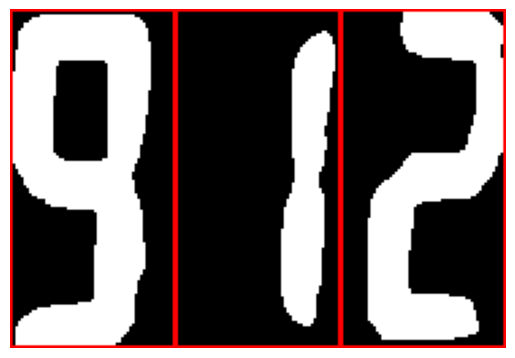

In [16]:
splited_area = cv2.cvtColor(margin_removed_img, cv2.COLOR_GRAY2BGR)
num_digits = 3
h, w = margin_removed_img.shape[:2]
one_digit_area = w // num_digits
for i in range(num_digits):
    splited_area = cv2.rectangle(
        splited_area,
        (one_digit_area * i, 0),
        (one_digit_area * (i + 1) - 1, h - 1),
        (255, 0, 0),
    )
cv2_imshow(splited_area)
# split_3_areas =

In [17]:
cv2.imwrite("../data/processed_images/processed_sample_sep_digit.png", splited_area)

True